In [1]:
import pandas as pd
import numpy as np

from elote import EloCompetitor, LambdaArena

import matplotlib.pyplot as plt

import random
import math

In [2]:
# Load in full matches and wrestlers dataframes
full_matches = pd.read_csv('MATCHES.csv').drop(columns="Unnamed: 0")
full_wrestlers = pd.read_csv('WRESTLERS.csv').drop(columns="Unnamed: 0")

In [3]:
full_matches.shape # number of matches, recorded match variables

(13652, 20)

In [4]:
full_matches.columns

Index(['Weight Class', 'Victory Type (L)', 'Victory Type (S)', 'Winner Score',
       'Loser Score', 'Winner First Name', 'Winner Last Name',
       'Winner School (L)', 'Winner School (S)', 'Loser First Name',
       'Loser Last Name', 'Loser School (L)', 'Loser School (S)',
       'Unknown (Seed?)', 'Round', 'Event Name', 'Event ID', 'Event Date',
       'Winner Full Name', 'Loser Full Name'],
      dtype='object')

In [5]:
full_matches

,Weight Class,Victory Type (L),Victory Type (S),Winner Score,Loser Score,Winner First Name,Winner Last Name,Winner School (L),Winner School (S),Loser First Name,Loser Last Name,Loser School (L),Loser School (S),Unknown (Seed?),Round,Event Name,Event ID,Event Date,Winner Full Name,Loser Full Name
0,285,Decision,Dec,0,4,Spencer,Dickinson,Whitehall-Fort Ann HS,WSH,Cody,Wilson,Albion HS,ALHS,15.0,Cons. Semis,NYSPHSAA D2 Wrestling Championships,4998204132,20200228,Spencer Dickinson,Cody Wilson
1,285,Fall,Fall,0,2,Spencer,Dickinson,Whitehall-Fort Ann HS,WSH,George,Lebberes,Ardsley,ARDS,15.0,Quarterfinals,NYSPHSAA D2 Wrestling Championships,4998204132,20200228,Spencer Dickinson,George Lebberes
2,285,Decision,Dec,3,1,Spencer,Dickinson,Whitehall-Fort Ann HS,WSH,Connor,Bushey,Beekmantown Sr HS,BSH,15.0,Champ. Round 1,NYSPHSAA D2 Wrestling Championships,4998204132,20200228,Spencer Dickinson,Connor Bushey
3,120,Fall,Fall,0,0,Patrick,Stinebaugh,Horace Mann School,HMS,Mason,Bush,Central Valley Academy,CVA,4.0,NaN,NYSPHSAA D2 Wrestling Championships,4998204132,20200228,Patrick Stinebaugh,Mason Bush
4,152,Fall,Fall,0,0,Liam,Futterman,Horace Mann School,HMS,Xavier,Giles,Eagle Academy Bronx-PSAL,EABX,9.0,NaN,NYSPHSAA D2 Wrestling Championships,4998204132,20200228,Liam Futterman,Xavier Giles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13647,220,Fall,Fall,0,3,Michael,Vandenburgh,Whitehall-Fort Ann HS,WSH,Marquize,Barmore,Schenectady,SCHE,14.0,3rd Place Match,`Coach Ken Baker Classic`,5040653132,20200131,Michael Vandenburgh,Marquize Barmore
13648,285,Fall,Fall,0,2,Kane,Losurdo,Red Hook Sr HS,RHSH,Spencer,Dickinson,Whitehall-Fort Ann HS,WSH,15.0,Quarterfinals,`Coach Ken Baker Classic`,5040653132,20200131,Kane Losurdo,Spencer Dickinson
13649,285,Fall,Fall,1,7,Conner,Pesce,Ichabod Crane Sr HS,ICSH,Spencer,Dickinson,Whitehall-Fort Ann HS,WSH,15.0,Semifinals,`Coach Ken Baker Classic`,5040653132,20200131,Conner Pesce,Spencer Dickinson
13650,285,Decision,Dec,4,1,Spencer,Dickinson,Whitehall-Fort Ann HS,WSH,Andrew,Dumas,Schuylerville-Greenwich Sr HS,SCGW,15.0,1st Place Match,`Coach Ken Baker Classic`,5040653132,20200131,Spencer Dickinson,Andrew Dumas


In [6]:
full_wrestlers.shape # number of wrestlers, recorded wrestler variables

(3896, 9)

In [7]:
full_wrestlers.columns

Index(['First Name', 'Last Name', 'Full Name', 'School Name', 'School Code',
       'Weight Class', 'Wins', 'Losses', 'Matches'],
      dtype='object')

In [8]:
full_wrestlers

,First Name,Last Name,Full Name,School Name,School Code,Weight Class,Wins,Losses,Matches
0,Julian,Tabb,Julian Tabb,White Plains Sr,WPS,152,2,2,4
1,Jacob,Schorsch,Jacob Schorsch,Horace Mann School,HMS,113,3,0,3
2,Edgar,Sandoval,Edgar Sandoval,Nyack Sr HS,NSH,120,0,10,10
3,Logan,Beebe,Logan Beebe,Granville Sr HS,GSH,195,0,8,8
4,Harry,Kelly,Harry Kelly,Carmel Sr,CASR,145,0,7,7
...,...,...,...,...,...,...,...,...,...
3891,Anthony,Holt,Anthony Holt,Chenango Valley Sr HS,CVSH,170,0,4,4
3892,Drew,Greco,Drew Greco,Warwick Valley HS,WVH,126,2,8,10
3893,Guy,Colabatistto,Guy Colabatistto,John Jay Sr -East Fishkill HS,JJSE,113,5,0,5
3894,Luke,Smeader,Luke Smeader,Hamburg Sr HS,HSH,126,2,6,8


In [9]:
# Drop matches decided by useless wincons like forfeit or bye (ASSUMPTION: these wincons don't imply wrestler ability)
bad_wins = ['Forfeit','Injury Default','Medical Forfeit','Bye','Disqualified','Default','No Contest']
win_filter = [win not in bad_wins for win in full_matches["Victory Type (L)"]]
MATCHES = full_matches.loc[win_filter].drop_duplicates().reset_index(drop=True) # dedupe seems to work now
# Go back and check if dedupe is removing more than it should -- maybe not distinguishing multiple bouts on same day
MATCHES.shape

(6630, 20)

In [10]:
# Copy infoscrape function from Wrestling Tables notebook

def infoscrape(fullname,df):
    '''infoscrape receives full name of wrestler and matches dataframe
    and collects wrestler info from dataset'''

    # Initialize values of interest
    weight_class = 0
    wins = 0
    losses = 0
    matches = 0
    school = ''
    school_code = ''
    first_name = ''
    last_name = ''
    
    # Find observations corresponding to wrestler name
    win_id = df['Winner Full Name'] == fullname
    loss_id = df['Loser Full Name'] == fullname
    winning_matches = df.loc[win_id,:]
    losing_matches = df.loc[loss_id,:]
    
    # Split full name
    first_name, last_name = fullname.split(' ',1)
    
    # Counting stats (should check if names show in correct columns for forfeits, byes, etc.)
    wins = sum(win_id)
    losses = sum(loss_id)
    matches = wins+losses
    
    # Extract weight class, school, etc.
    win_weight = winning_matches['Weight Class'].unique()
    loss_weight = losing_matches['Weight Class'].unique()
    
    if win_weight.size > 0: # Avoiding 'if win_weight:' because it gives truth amibiguity warning
        weight_class = int(win_weight[0])
    else: # !!!Still need to add consideration for multiple weight classes!!!
        weight_class = int(loss_weight[0])
        
    win_school = winning_matches['Winner School (L)'].unique()
    win_school_code = winning_matches['Winner School (S)'].unique()
    loss_school = losing_matches['Loser School (L)'].unique()
    loss_school_code = losing_matches['Loser School (S)'].unique()
    
    if win_school.size > 0: # Avoiding 'if win_school:' because it gives truth amibiguity warning
        school = win_school[0]
        school_code = win_school_code[0]
    else: 
        school = loss_school[0]
        school_code = loss_school_code[0]
        
    # Return list of extracted data 
    return({'First Name':first_name,'Last Name':last_name,'Full Name':fullname,
            'School Name':school,'School Code':school_code,
            'Weight Class':weight_class,'Wins':wins,'Losses':losses,'Matches':matches})

In [11]:
# Remake wrestlers df
# Note: union of winner/loser full names is set of all wrestlers in dataset
wrestlers = set(MATCHES['Winner Full Name']) | set(MATCHES['Loser Full Name'])
wrestlers = [x for x in wrestlers if x==x] # remove nan, convert to list
wrestler_data = [infoscrape(wrestler,MATCHES) for wrestler in wrestlers]
WRESTLERS = pd.DataFrame(wrestler_data)

In [12]:
WRESTLERS.shape

(3868, 9)

In [13]:
# Function to create train and test data split by date of wrestling events
# Note: research paper trained on one weight class and tested on all the rest.
# Why this is a big separate function: have to remake wrestlers dataframe from filtered matches dataframe

def train_test_split(match_data, wrestler_data=None, split_method='date',
                    earliest=None, latest=None, train_size=0.75):
    '''train_test_split creates train and test data using given match data.
    Can split by date range for train set or desired train data size (default is date).
    Train_size is between 0 and 1. earliest/latest are dates in format YYYYMMDD.
    Returns dict of match_train, match_test, wrestler_train, wrestler_test.'''
    
    event_dates = match_data["Event Date"]
    
    # Default dates
    if earliest is None:
        earliest = min(event_dates)
    if latest is None:
        latest = max(event_dates)
    
    # Handle input exceptions        
    if latest > max(event_dates):
        raise ValueError('Invalid indexing: latest ({}) cannot be after most recent event ({})'\
                         .format(latest,max(event_dates)))
    if earliest >= latest:
        raise ValueError('Invalid indexing: earliest ({}) must be less than latest ({})'\
                         .format(earliest,latest))
        
    # Train-Test Split
    
    if split_method == 'size': # split by train_size
        
        indices = match_data.index.values
        n = len(indices)
        train_start = int(np.quantile(indices,q=1-train_size))
        train_id = range(train_start,n)
        test_id = range(0,train_start)
        match_train = match_data.iloc[train_id,:]
        match_test = match_data.iloc[test_id,:]
        
    if split_method == 'date': # split by date range
        
        date_range = range(earliest,latest+1)
        train_bool = [date in date_range for date in event_dates]
        test_bool = [not index for index in train_bool]
        match_train = match_data.loc[train_bool]
        match_test = match_data.loc[test_bool]
        
        
    # Name wrestlers to train or test sets
    wrestler_names_train = set(match_train['Winner Full Name']) | set(match_train['Loser Full Name'])
    wrestler_names_train = [x for x in wrestler_names_train if x==x] # remove nan, convert to list
    
    # Not sure if making wrestler test set like this makes total sense but I'll do it for now
    # Maybe because of cumulative stats, wrestler test set is always up-to-date full wrestler data?
    wrestler_names_test = set(match_test['Winner Full Name']) | set(match_test['Loser Full Name'])
    wrestler_names_test = [x for x in wrestler_names_test if x==x] # remove nan, convert to list

    # Call infoscrape to construct wrestler dataframes
    wrestler_train = [infoscrape(wrestler,match_train) for wrestler in wrestler_names_train]
    wrestler_train = pd.DataFrame(wrestler_train)
    wrestler_test = [infoscrape(wrestler,match_test) for wrestler in wrestler_names_test]
    wrestler_test = pd.DataFrame(wrestler_test)
    
    # Store train/test splits in dict
    train_test_dict = {"match_train":match_train,"match_test":match_test,
                      "wrestler_train":wrestler_train,"wrestler_test":wrestler_test}
    
    return(train_test_dict)

In [14]:
def closest(arr, K): 
    '''returns the item in arr closest to the value K'''
    idx = (np.abs(arr - K)).argmin() 
    return(arr[idx])

In [15]:
def win_perc_pred(wrestler1,wrestler2,wrestler_train,wrestler_test,match_train,match_test):
    '''win_perc_pred makes a simple prediction that the winner of a match between
    wrestler1 and wrestler2 will be the wrestler with the higher win percentage. Uses wrestlers' fullnames.'''
    
    # Note: this predictor doesn't use match data for now, but I want to 
    # keep the algorithm inputs consistent for evaluation --> alg  args dict
    
    # log_dict to track when defaulting to school WP or matches WP, or other info tidbits
    
    # add confidence measure based on difference in WPs
    
    # Wrestler 1
    wrestler1_bool = wrestler_train["Full Name"]==wrestler1 # should add school clarification step for same names
    
    if sum(wrestler1_bool) == 0: # wrestler not in train set, try to use their school's average WP
        
        wrestler1_bool = wrestler_test["Full Name"]==wrestler1
        school = wrestler_test.loc[wrestler1_bool]["School Name"].values[0]
            
        if sum(wrestler_train["School Name"]==school) == 0: # No other wrestlers from school in data :( 
            # Try using average win perc of all wrestlers with same number of matches (experience counts!)
            
            test_match_num = wrestler_test.loc[wrestler1_bool]["Matches"].values[0]
            wrestlers_by_matches = wrestler_train.groupby("Matches")
            wins_by_match = wrestlers_by_matches["Wins"].mean()
            train_match_num = closest(wins_by_match.index.values,test_match_num)            
            win_perc_1 = wins_by_match[train_match_num] / train_match_num
            
        else: # School WP
            wrestlers_by_school = wrestler_train.groupby("School Name")
            win_perc_1 = wrestlers_by_school["Wins"].mean()[school] / wrestlers_by_school["Matches"].mean()[school]

    else: # wrestler 1 in train set, has their own WP
        win_perc_1 = wrestler_train.loc[wrestler1_bool]["Wins"] / wrestler_train.loc[wrestler1_bool]["Matches"]
        win_perc_1 = win_perc_1.values[0]

        
    # Wrestler 2
    wrestler2_bool = wrestler_train["Full Name"]==wrestler2 # should add school clarification step for same names
    
    if sum(wrestler2_bool) == 0: # wrestler not in train set, try to use their school's average WP
    
        wrestler2_bool = wrestler_test["Full Name"]==wrestler2
        school = wrestler_test.loc[wrestler2_bool]["School Name"].values[0]
        
        if sum(wrestler_train["School Name"]==school) == 0: # No other wrestlers from school in data :( 
            # Try using average win perc of all wrestlers with same/closest number of matches (experience counts!)

            test_match_num = wrestler_test.loc[wrestler2_bool]["Matches"].values[0]
            wrestlers_by_matches = wrestler_train.groupby("Matches")
            wins_by_match = wrestlers_by_matches["Wins"].mean()
            train_match_num = closest(wins_by_match.index.values,test_match_num)            
            win_perc_2 = wins_by_match[train_match_num] / train_match_num
        
        else: # School WP
            wrestlers_by_school = wrestler_train.groupby("School Name")
            win_perc_2 = wrestlers_by_school["Wins"].mean()[school] / wrestlers_by_school["Matches"].mean()[school]
            
    else: # wrestler 2 in train set, has their own WP
        win_perc_2 = wrestler_train.loc[wrestler2_bool]["Wins"] / wrestler_train.loc[wrestler2_bool]["Matches"]
        win_perc_2 = win_perc_2.values[0]

    
    # Do we want a minimal difference to declare a decision?
    wp_diff = abs(win_perc_1 - win_perc_2) 
    # Reformat this into a more general confidence measure -> e.g. 0.0-0.25 == "*", 0.25-0.5 == "**", etc.
    
    if win_perc_1 > win_perc_2:
        return({"Winner":wrestler1,"Confidence":wp_diff})
    elif win_perc_1 == win_perc_2:
        return({"Winner":None,"Confidence":wp_diff}) # TODO: Track these in validation
    else:
        return({"Winner":wrestler2,"Confidence":wp_diff})

In [16]:
# Elo
# Use groupby method on wrestler/match data to get initial values for unranked players?
# Determine ratings by train data; maybe check which update frequency works best for prediction?

# General idea:
# Doesn't need two specific wrestlers; can form elo rankings just off wrestlers+matches train/test sets
# Can then accept two wrestlers to see whose elo ranking is higher and get predicted winner
# So the rankings are essentially defined by the train set cutoff

# Need to consider what initial ranking values should be for different wrestlers
## Could just start every wrestler off with same initial ranking
## Can take whole train set, group by team names, and form initial rankings for each player based on team rankings?
#### feels kind of contrived, how would I determine the initial rating a team deserves?
#### could have t distinct elo rankings, t is number of teams, and assign best ranking to best team by... win percentage?
## Remember that wrestler in test set may not be in train set, needs default value as well

# Notes/Thoughts:
# Rank wrestlers as a whole or within their weight class?
# 

In [17]:
def elo_matchups(match_train):
    
    train_matchups = list()
    
    for idx, row in match_train.iterrows():
        train_matchups.append((
            row['Winner Full Name'],
            row['Loser Full Name']
        ))
        
    return(train_matchups)

In [18]:
def elote_func(a, b): # Currenly trivial since winner is already known to be first entry, a
    return True

In [19]:
# Elo support provided via elote package by Will McGinnis @ wdm0006 on GitHub
# Remember to make this input a generic alg_args dict when that gets changed

def elo_rank(match_train,initial=1000,K=225):
    '''elo_rank takes in match data along with elo tuning params and returns an ordered ranking of wrestlers'''
    
    # Put matches in true date order (date format is YYYYMMDD)
    match_train.sort_values(by="Event Date",inplace=True)
    
    # Form train matchups. For this, winner will always be first listed in each matchup.
    train_matchups = elo_matchups(match_train)
    
    # Create arena and process train matches
    arena = LambdaArena(elote_func)
    arena.set_competitor_class_var('_k_factor',K)
    arena.set_competitor_class_var('_base_rating',initial)
    arena.tournament(train_matchups)
    
    
    # Return rankings and arena, post-train matches
    rankings = sorted(arena.leaderboard(), reverse=True, key=lambda x: x.get('rating'))
    saved_state = arena.export_state()
    return({"Rankings":rankings,
            "Saved Arena":saved_state})



In [26]:
# Make some potentially useful elo ranking dictionaries

def elo_rank_dicts(raw_rankings):
    
    wrestlers_with_rankings = {} # keys are wrestlers, values are (rankings,ratings)
    rankings_with_wrestlers = {} # keys are rankings, (wrestlers,ratings) are values

    for index, comp_dict in enumerate(raw_rankings):
        rank = index + 1
        wrestler,rating = comp_dict.values()
        rating = round(rating,3)
        wrestlers_with_rankings[wrestler] = (rank,rating)
        rankings_with_wrestlers[rank] = (wrestler,rating)
        
    return({"Ranked Wrestlers":wrestlers_with_rankings,
            "Named Rankings":rankings_with_wrestlers})

In [33]:
def elo_pred(wrestler1,wrestler2,wrestler_train,wrestler_test,match_train,match_test): # alg_args please
    '''elo_pred predicts the winner of a bout to be the wrestler with the higher elo ranking'''
    
    # currently very inefficient because it calls elo_rank for each pairing
    # have to change that ASAP
    
    # Raw rankings
    elo_rank_output = elo_rank(match_train)
    elo_rankings = elo_rank_output["Rankings"]
    
    # Nicer dicts
    nice_dicts = elo_rank_dicts(elo_rankings)
    ranked_wrestlers = nice_dicts["Ranked Wrestlers"]
    named_rankings = nice_dicts["Named Rankings"]
    
    ## initial_state arg for arena call doesn't seem to work, commented out dependent code and implemented temp solution
    
    # Extract,implement arena info 
    #saved_state = elo_rank_output["Saved Arena"]
    #arena = LambdaArena(elote_func,initial_state=saved_state)
    
    # Simulate wrestlers' bout
    #winprob1 = arena.expected_score(wrestler1,wrestler2) # probability of wrestler1 beating wrestler2
    # Do we want a minimal difference to declare a decision?
    # Can reformat this into a more general confidence measure
    #prob_diff = abs(2*(winprob1 - 0.5))

    
    #if winprob1 > 0.5:
    #    return({"Winner":wrestler1,"Confidence":prob_diff})
    #elif winprob1 == 0.5:
    #    return({"Winner":None,"Confidence":prob_diff}) # TODO: Track these in validation
    #else:
    #    return({"Winner":wrestler2,"Confidence":prob_diff})
    
    
    # Temp solution
    default_ranking = int(len(ranked_wrestlers)/2)
    
    if wrestler1 not in ranked_wrestlers.keys():
        rank1 = default_ranking
    else:
        rank1 = ranked_wrestlers[wrestler1][0]
        
    if wrestler2 not in ranked_wrestlers.keys():
        rank2 = default_ranking
    else:
        rank2 = ranked_wrestlers[wrestler2][0]
        
    rank_diff = abs(rank1-rank2) # need to make this a comparable confidence format; see Win Percentage Pred function
    
    
    if rank1 > rank2:
        return({"Winner":wrestler1,"Confidence":rank_diff})
    elif rank1==rank2:
        return({"Winner":None,"Confidence":rank_diff}) # TODO: Track these in validation
    else:
        return({"Winner":wrestler2,"Confidence":rank_diff})
    

In [22]:
def matchmaker(match_test):
    '''matchmaker takes in match test data and returns a list of 
    the associated wrestler matchup pairs'''
    
    
    test_matchups = []
    
    for i in range(0,match_test.shape[0]):
        match = match_test.loc[i]
        w1 = match["Winner Full Name"]
        w2 = match["Loser Full Name"]
        
        # nan entry -> just have wrestler go against himself for now (should result in no winner)
        # no option for both nan, but that is a datapoint I don't even want
        if w1!=w1:
            w1 = w2
        elif w2!=w2:
            w2 = w1
        
        test_matchups.append((w1,w2))
        
    return(test_matchups)

In [23]:
def test_algorithm(algorithm,match_train,match_test,wrestler_train,wrestler_test):
    '''test_algorithm implements a given algorithm using given wrestler and match 
    train/test data and returns prediction accuracy'''
    
    # Extract matchups from test matches
    test_matchups = matchmaker(match_test)

    # True and predicted winners
    true_winners = match_test["Winner Full Name"] 
    pred_output = [algorithm(W1,W2,wrestler_train,wrestler_test,match_train,match_test) for W1,W2 in test_matchups]
    pred_winners = [output["Winner"] for output in pred_output]
    pred_confidences = [output["Confidence"] for output in pred_output] # make this more general for new algs
    
    # Calculate prediction accuracy, save incorrect pred info
    pred_results = true_winners == pred_winners
    incorrect_preds = match_test.loc[true_winners != pred_winners,:]
    n = len(pred_results)
    correct = sum(pred_results)
    incorrect = n - correct
    pred_accuracy = pred_results.mean()
    
    return({"Accuracy":pred_accuracy,"NumCorrect":correct,"NumIncorrect":incorrect,"N":n,
           "WrongPreds":incorrect_preds, "PredConfidences":pred_confidences})

In [ ]:
# See if functions do their job

In [24]:
# Define train/test sets

# Should probably scrape by event date, especially for elo

train_test_dict = train_test_split(MATCHES,split_method='size',train_size=0.8) # takes a minute because infoscrape function
match_train = train_test_dict["match_train"]
wrestler_train = train_test_dict["wrestler_train"]
match_test = train_test_dict["match_test"]
wrestler_test = train_test_dict["wrestler_test"]

In [34]:
# Test elo algorithm
# Note: create algorithm_args dict argument for algorithms and algorithm tester
elo_pred_results = test_algorithm(elo_pred,match_train,match_test,wrestler_train,wrestler_test)

C:\Users\colum\Anaconda3\envs\webscraping\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 5305/5305 [00:00<00:00, 69953.20it/s]


100%|██████████| 5305/5305 [00:00<00:00, 94979.22it/s]


100%|██████████| 5305/5305 [00:00<00:00, 105890.56it/s]


100%|██████████| 5305/5305 [00:00<00:00, 66447.42it/s]


100%|██████████| 5305/5305 [00:00<00:00, 108479.02it/s]


100%|██████████| 5305/5305 [00:00<00:00, 54278.28it/s]


100%|██████████| 5305/5305 [00:00<00:00, 98171.57it/s]


100%|██████████| 5305/5305 [00:00<00:00, 59754.82it/s]


100%|██████████| 5305/5305 [00:00<00:00, 42552.25it/s]


100%|██████████| 5305/5305 [00:00<00:00, 72855.93it/s]


In [36]:
elo_pred_results['Accuracy']

0.3230188679245283

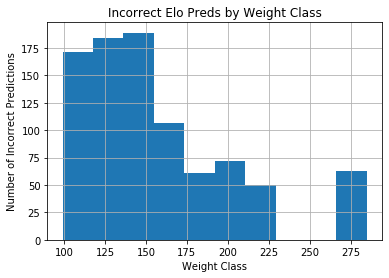

In [38]:
# Show distribution of weight classes among wrestlers in incorrect pred cases
# Misleading: should scale by num wrestler/matches in weight class
# Note: make this a bar chart instead if possible
elo_pred_results['WrongPreds'].hist(column="Weight Class")
plt.xlabel("Weight Class")
plt.ylabel("Number of Incorrect Predictions")
plt.title("Incorrect Elo Preds by Weight Class")

# Save fig
plt.savefig('./Plots/Elo/incorrect_preds_weight_class.png')

Text(0.5, 1.0, 'Incorrect Elo Preds by Event Date')

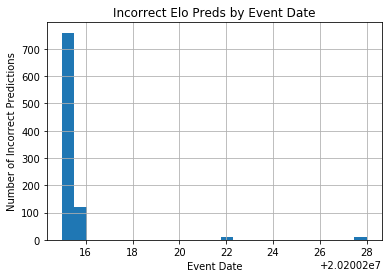

In [45]:
# Show distribution of weight classes among wrestlers in incorrect pred cases
# Misleading: should scale by num wrestler/matches in weight class
# Note: make this a bar chart instead if possible
elo_pred_results['WrongPreds'].hist(column="Event Date",bins=25)
plt.xlabel("Event Date")
plt.ylabel("Number of Incorrect Predictions")
plt.title("Incorrect Elo Preds by Event Date")
# fix x axis scale

In [47]:
# Test win percentage algorithm
# Note: create algorithm_args dict argument for algorithms and algorithm tester
WP_pred_results = test_algorithm(win_perc_pred,match_train,match_test,wrestler_train,wrestler_test)

In [48]:
WP_pred_results['Accuracy']

0.5275471698113208

In [ ]:
# Algorithm diagnostics


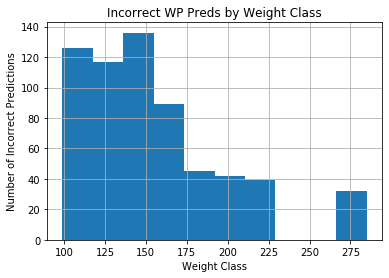

In [49]:
# Show distribution of weight classes among wrestlers in incorrect pred cases
# Misleading: should scale by num wrestler/matches in weight class
# Note: make this a bar chart instead if possible
WP_pred_results['WrongPreds'].hist(column="Weight Class")
plt.xlabel("Weight Class")
plt.ylabel("Number of Incorrect Predictions")
plt.title("Incorrect WP Preds by Weight Class")

# Save fig
plt.savefig('./Plots/WinPerc/incorrect_preds_weight_class.png')

Text(0.5, 1.0, 'Incorrect WP Preds by Event Date')

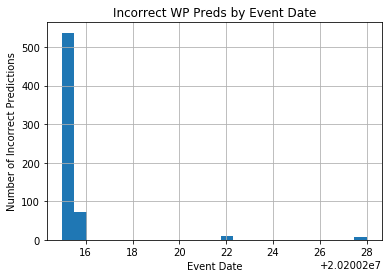

In [50]:
# Show distribution of weight classes among wrestlers in incorrect pred cases
# Misleading: should scale by num wrestler/matches in weight class
# Note: make this a bar chart instead if possible
WP_pred_results['WrongPreds'].hist(column="Event Date",bins=25)
plt.xlabel("Event Date")
plt.ylabel("Number of Incorrect Predictions")
plt.title("Incorrect WP Preds by Event Date")
# fix x axis scale

In [ ]:
# See predictive power of WP on this dataset by shrinking train data size
train_sizes = np.linspace(start=0.5,stop=1.0,num=6)
accuracy_dict = {}

for size in train_sizes:
    
    train_test_dict = train_test_split(MATCHES,split_method='size',train_size=size)
    match_train = train_test_dict["match_train"]
    wrestler_train = train_test_dict["wrestler_train"]
    match_test = train_test_dict["match_test"]
    wrestler_test = train_test_dict["wrestler_test"]
    
    WP_pred_results = test_algorithm(win_perc_pred,match_train,match_test,wrestler_train,wrestler_test)
    
    accuracy_dict[size] = WP_pred_results['Accuracy']

In [ ]:
# Plot results
plt.bar(range(len(accuracy_dict)), list(accuracy_dict.values()), align='center')
plt.xticks(range(len(accuracy_dict)), list(accuracy_dict.keys()))
plt.title('Prediction Accuracy')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')

# Save fig
plt.savefig('./Plots/WinPerc/win_perc_pred_accuracy.png')

plt.show()

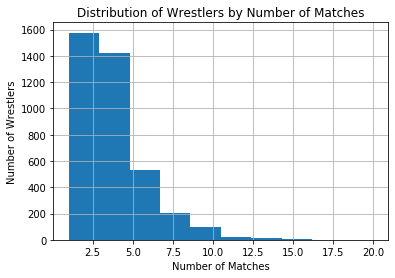

In [51]:
# Show distribution of number of matches among wrestlers
WRESTLERS.hist(column="Matches")
plt.xlabel("Number of Matches")
plt.ylabel("Number of Wrestlers")
plt.title("Distribution of Wrestlers by Number of Matches")

# Save fig
plt.savefig('./Plots/EDA/wrestler_match_dist.png')

# Vast majority of wrestlers have less than 15 matches

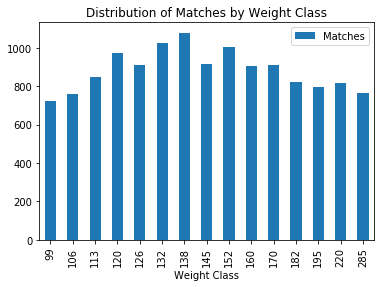

In [52]:
# Show distribution of matches by weight class
wrestlers_by_weight = WRESTLERS.groupby('Weight Class')
wrestlers_by_weight.sum().plot.bar(y="Matches")
plt.title("Distribution of Matches by Weight Class")

# Save fig
plt.savefig('./Plots/EDA/matches_by_weight_class.png')

# Fairly balanced weight classes; flattened bell curve

In [ ]:
# Check count of matches by victory type 
# There are nan entries for Victory Type (L)
#matches_by_wintype = MATCHES.groupby('Victory Type (L)')
#matches_by_wintype.describe()['Match ID'].plot.bar(y='count')
#plt.title("Distribution of Matches by Victory Type")

# Save fig
#plt.savefig('./Plots/matches_by_win_type.png')

# Practically all victory types are fall or decision

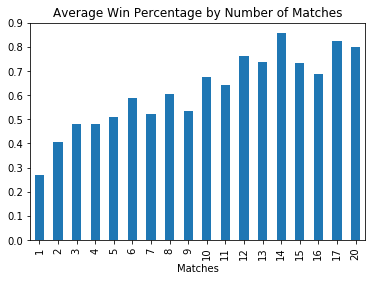

In [53]:
# Show distribution of avg win perc by matches
wrestlers_by_matches = WRESTLERS.groupby('Matches')
avg_wins = wrestlers_by_matches.mean()['Wins']
num_matches = avg_wins.index.values
win_percs = avg_wins / num_matches
win_percs.plot.bar()
plt.title("Average Win Percentage by Number of Matches")

# Save fig
plt.savefig('./Plots/WinPerc/win_percs_by_matches.png')

# Does win percentage increase with number of matches?
# More matches means more experience, but also consider that you may only get more matches if you're already winning
# Some positive correlation, as expected